_Черненко А.Е._
# <center>Построение модели классификации<center>

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import r2_score, f1_score, precision_score, recall_score, classification_report
import catboost as catb
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
MODEL_AI_FILE_PATH = 'model_AI.pkl'
MODEL_CS_FILE_PATH = 'model_CS.pkl'
MODEL_CLA_FILE_PATH = 'model_CLA.pkl'

MODEL_FILE_PATH = 'final_model.pkl'

c:\users\aech\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Обзор обучающего датасета

### Смысловое описание признаков

* __Home Ownership__ `HO` - домовладение
* __Annual Income__ `AI` - годовой доход
* __Years in current job__ `YCJ` - количество лет на текущем месте работы
* __Tax Liens__ `TL` - налоговые обременения
* __Number of Open Accounts__ `NOA` - количество открытых счетов
* __Years of Credit History__ `YCH` - количество лет кредитной истории
* __Maximum Open Credit__ `MOC` - наибольший открытый кредит
* __Number of Credit Problems__ `NCP` - количество проблем с кредитом
* __Months since last delinquent__ `MSLD` - количество месяцев с последней просрочки платежа
* __Bankruptcies__ `B` - банкротства
* __Purpose__ `P` - цель кредита
* __Term__ `T` - срок кредита
* __Current Loan Amount__ `CLA` - текущая сумма кредита
* __Current Credit Balance__ `CCB` - текущий кредитный баланс
* __Monthly Debt__ `MD` - ежемесячный долг
* __Credit Score__ `CS` - кредитный рейтинг
* __Credit Default__ `CD` - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

Загрузим тренировочный датасет в переменную `df`. 

Для удобства работы определим список аббревиатур для названий признаков, словарь типа _{аббревиатура : полное название признака}_ , а в датасете заменим полные названия признаков аббревиатурами.

In [2]:
df = pd.read_csv(TRAIN_DATASET_PATH)

SHORT_COLUMNS = ['HO','AI','YCJ','TL','NOA','YCH','MOC','NCP','MCLD','B','P','T','CLA','CCB','MD','CS','CD']
DICT_COLUMNS = dict(zip(SHORT_COLUMNS, df.columns))  # словарь {аббревиатура : полное_название}
df.columns = SHORT_COLUMNS

df.head(3)

,HO,AI,YCJ,TL,NOA,YCH,MOC,NCP,MCLD,B,P,T,CLA,CCB,MD,CS,CD
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


### Краткое резюме по данным признаков

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HO      7500 non-null   object 
 1   AI      5943 non-null   float64
 2   YCJ     7129 non-null   object 
 3   TL      7500 non-null   float64
 4   NOA     7500 non-null   float64
 5   YCH     7500 non-null   float64
 6   MOC     7500 non-null   float64
 7   NCP     7500 non-null   float64
 8   MCLD    3419 non-null   float64
 9   B       7486 non-null   float64
 10  P       7500 non-null   object 
 11  T       7500 non-null   object 
 12  CLA     7500 non-null   float64
 13  CCB     7500 non-null   float64
 14  MD      7500 non-null   float64
 15  CS      5943 non-null   float64
 16  CD      7500 non-null   int64  
dtypes: float64(12), int64(1), object(4)
memory usage: 996.2+ KB


* **Признаки AI, YCJ, MCLD, B, CS имеют пропущенные значения.**
* **Признаки HO, YCJ, P, T объектные, остальные - количественные.**

### Обзор количественных признаков

In [4]:
df.describe().round(3)

,AI,TL,NOA,YCH,MOC,NCP,MCLD,B,CLA,CCB,MD,CS,CD
count,5943.00,7500.000,7500.000,7500.000,7.500000e+03,7500.000,3419.000,7486.000,7.500000e+03,7500.000,7500.000,5943.000,7500.000
mean,1366391.72,0.030,11.131,18.317,9.451537e+05,0.170,34.693,0.117,1.187318e+07,289833.235,18314.454,1151.087,0.282
std,845339.20,0.272,4.909,7.042,1.602622e+07,0.499,21.689,0.347,3.192612e+07,317871.382,11926.765,1604.451,0.450
min,164597.00,0.000,2.000,4.000,0.000000e+00,0.000,0.000,0.000,1.124200e+04,0.000,0.000,585.000,0.000
25%,844341.00,0.000,8.000,13.500,2.792295e+05,0.000,16.000,0.000,1.801690e+05,114256.500,10067.500,711.000,0.000
50%,1168386.00,0.000,10.000,17.000,4.781590e+05,0.000,32.000,0.000,3.095730e+05,209323.000,16076.500,731.000,0.000
75%,1640137.00,0.000,14.000,21.800,7.935015e+05,0.000,50.000,0.000,5.198820e+05,360406.250,23818.000,743.000,1.000
max,10149344.00,7.000,43.000,57.700,1.304726e+09,7.000,118.000,4.000,1.000000e+08,6506797.000,136679.000,7510.000,1.000


Предположительно:
* AI - непрерывная величина, требует анализ на выбросы
* TL - дискретная величина
* NOA - дискретная величина
* YCH - непрерывная величина, требует анализ на выбросы
* MOC - непрерывная величина, требует анализ на выбросы и нули
* NCP - дискретная величина
* MCLD - дискретная величина
* B - дискретная величина
* CLA - непрерывная величина, требует анализ на выбросы
* CCB - непрерывная величина, требует анализ нулей
* MD - непрерывная величина, требует анализ нулей
* CS - непрерывная величина, требует анализ на выбросы

### Обзор номинативных признаков

In [5]:
for col_name in df.select_dtypes(include='object').columns:
    print(DICT_COLUMNS[col_name], f'({col_name})')
    print()
    print(df[col_name].value_counts())
    print('*'*30)
    print()

Home Ownership (HO)

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: HO, dtype: int64
******************************

Years in current job (YCJ)

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: YCJ, dtype: int64
******************************

Purpose (P)

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: P, dtype: int64
******************************

Term (T)

Short Term    5556
Long Term     1944
Name

## Обработка выбросов

Как уже рассматривалось выше в обзоре проанализируем следующие количественные признаки на выбросы и нули:
* AI 
* YCH
* MOC
* CLA
* CCB
* CCB
* CS

Анализировать выбросы будем по графикам "Ящик с усами" и плотности распределения.

In [6]:
def show_feature_outliers(dataframe, feature_name):
    plt.figure(figsize = (12,4))
    
    plt.subplot(1,2,1)
    plt.boxplot(dataframe.loc[df[feature_name].notna(),feature_name])
    
    plt.subplot(1,2,2)
    sns.distplot(dataframe.loc[df[feature_name].notna(),feature_name])

#### Annual Income (AI, годовой доход)

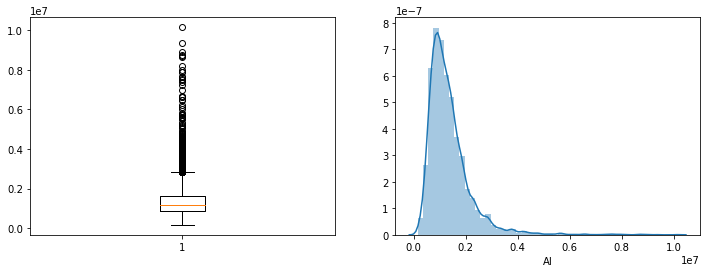

In [7]:
show_feature_outliers(df, 'AI')

Имеется длинный хвост распределения. Очевидных выбросов нет. По смыслу значения так же правдоподобны. Распределение похоже на логнормальное.
####  Years of Credit History  (YCH, количество лет кредитной истории)

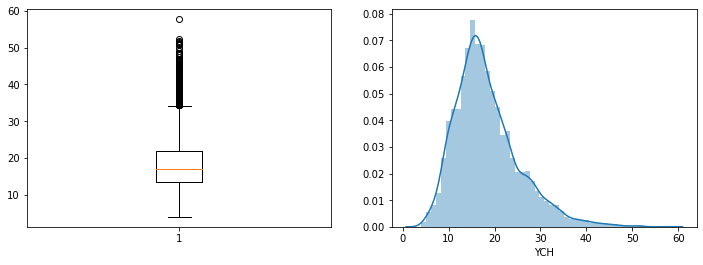

In [8]:
show_feature_outliers(df, 'YCH')    

Имеется небольшой хвост распределения. Очевидных выбросов нет. По смыслу значения так же правдоподобны. Распределение похоже на логнормальное.
#### Maximum Open Credit (MOC, наибольший открытый кредит)

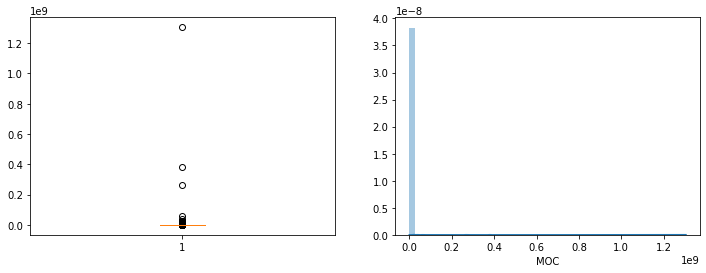

In [9]:
show_feature_outliers(df, 'MOC')

Наблюдаются выбросы, установим по ним порог в 10 млн.

In [10]:
moc_count = df.loc[df['MOC']>10000000, 'MOC'].count()
print('Выбросов больше 10 млн.:', moc_count, 'шт.')

Выбросов больше 10 млн.: 19 шт.


Заменим выбросы и нули медианой и проверим распределение. Если CCB == 0, то тогда нулвое значение в MOC заменяем медианой.
Выбросы больше 10 млн, заменяем соответствующим в данном наблюдении удвоенным значением CCB

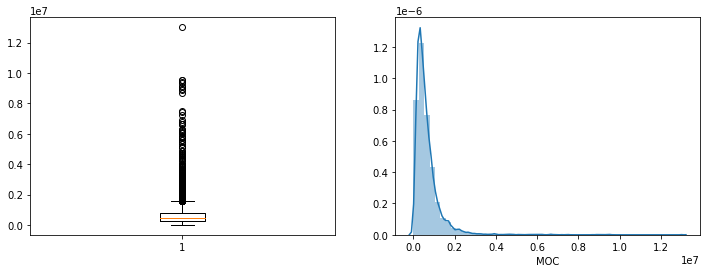

In [11]:
def outlier_MOC(df):
    df.loc[(df['MOC']==0) & (df['CCB']!=0),'MOC'] = df['MOC'].median()
    df.loc[df['MOC']>10**7,'MOC'] = df.loc[df['MOC']>10**7,'CCB']/0.5
    
outlier_MOC(df)

show_feature_outliers(df, 'MOC')

Распределение похоже на логнормальное.

#### Current Loan Amount (CLA, текущая сумма кредита)

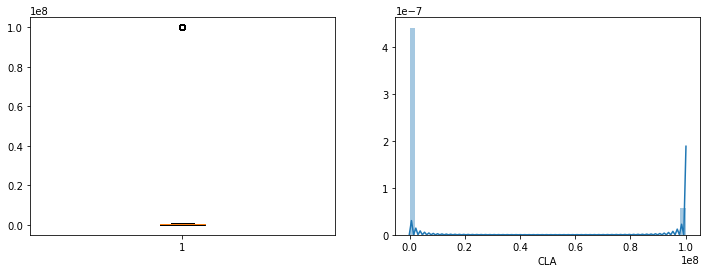

In [12]:
show_feature_outliers(df, 'CLA')

При том же пороге в 10 млн. наблюдается 870 выбросов с одним значением 99999999.0:

Будем предсказывать значения выбросов с помощью регрессии.

In [13]:
df.loc[df['CLA']>10000000, 'CLA'].value_counts()

99999999.0    870
Name: CLA, dtype: int64

#### Current Credit Balance (CCB, текущий кредитный баланс)
Значния CCB, которые больше соответствующих им MOC, заменям половинным значенем соответствующих MOC

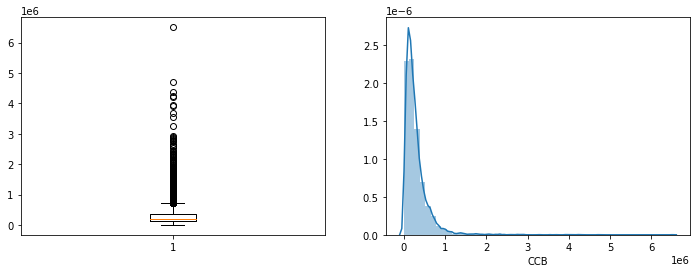

In [14]:
def outlier_CCB(df):
    df.loc[df['CCB']>df['MOC'],'CCB'] = df.loc[df['CCB']>df['MOC'],'MOC']*0.5
    
    
show_feature_outliers(df, 'CCB')

Распределение похоже на логнормальное.

#### Monthly Debt  (MD, ежемесячный долг)
Проанализируем объекты с нулевыми значениями в признааке:

In [15]:
print('Количество нулей:', df.loc[df['MD']==0,'MD'].count())
df.loc[df['MD']==0]

Количество нулей: 6


,HO,AI,YCJ,TL,NOA,YCH,MOC,NCP,MCLD,B,P,T,CLA,CCB,MD,CS,CD
780,Home Mortgage,867749.0,10+ years,0.0,2.0,16.5,0.0,0.0,66.0,0.0,home improvements,Short Term,75350.0,0.0,0.0,704.0,0
1643,Rent,NaN,9 years,0.0,3.0,10.0,0.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,NaN,10+ years,0.0,3.0,18.5,0.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
3496,Rent,233567.0,1 year,0.0,7.0,11.7,0.0,0.0,0.0,NaN,educational expenses,Short Term,210166.0,0.0,0.0,746.0,0
4165,Rent,1254513.0,10+ years,0.0,6.0,23.4,0.0,0.0,60.0,0.0,take a trip,Short Term,99999999.0,0.0,0.0,748.0,0
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


Оставим нули.

#### Credit Score (CS, кредитный рейтинг)

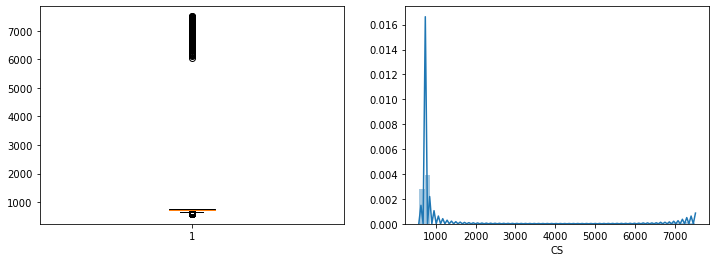

In [16]:
show_feature_outliers(df, 'CS')

Очевидные выбросы:

In [17]:
df.loc[df['CS'] > 2000, 'CS'].head(3)

69    6470.0
87    7440.0
94    7010.0
Name: CS, dtype: float64

Видна закономерность ошибки, которая исправляется путем деления на 10

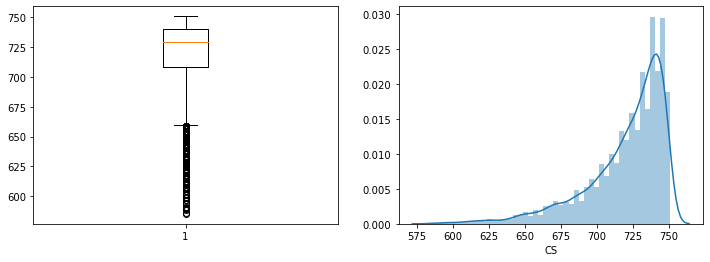

In [18]:
def outlier_CS(df):
    df.loc[df['CS'] > 800, 'CS'] /= 10

outlier_CS(df)
    
show_feature_outliers(df, 'CS')

#### Home Ownership (HO, домовладение)
Очевидно, что Home Mortgage и Have Mortgage имеют одинаковый смысл, поэтому объединим эти категории

In [19]:
def outlier_HO(df):
    df.loc[df['HO']=='Have Mortgage','HO'] = 'Home Mortgage'

outlier_HO(df)

__Обощенная функция обработки выбросов:__

In [20]:
def prep_outlier(df):
    outlier_MOC(df)
    outlier_CCB(df)
    outlier_CS(df)
    outlier_HO(df)

## Обработка пропусков
Имеют пропущенные значения следущие признаки:
* AI
* YCJ
* MCLD
* B
* CS

In [21]:
for ft in ['AI','YCJ','MCLD','B','CS']:
    print(f'Пропусков в "{ft}":\t{df.loc[df[ft].isna(), ft].shape[0]} шт.')

print()
print()
print('Наблюдений, в которых AI и CS одновременно пропущены :', df.loc[df['AI'].isna(), ['AI','CS']].shape[0])

Пропусков в "AI":	1557 шт.
Пропусков в "YCJ":	371 шт.
Пропусков в "MCLD":	4081 шт.
Пропусков в "B":	14 шт.
Пропусков в "CS":	1557 шт.


Наблюдений, в которых AI и CS одновременно пропущены : 1557


Заполним пропуски в YCJ и B модальными значениями, удалим признак MCLD и создадим общую функцию обработки пропусков.


Пропуски в AI и CS исправим с помощью регрессии "случайным лесом" позже после окончательного анализа и отбора признаков с целью использования их в качестве обучающих данных.

In [22]:
def prep_fillna(df):
    df['YCJ'].fillna(df['YCJ'].mode()[0], inplace=True)
    df['B'].fillna(df['B'].mode()[0], inplace=True)    
    df.drop(['MCLD'], inplace=True, axis=1)
    

prep_fillna(df)

### Перевод объектных признаков в категорийные

In [23]:
def obj_to_cat(df):
    cat_feats = list(df.columns[df.dtypes==object])
    for cat_feat in cat_feats:
        df[cat_feat] = pd.Categorical(df[cat_feat])
    return cat_feats

CAT_FEATS = obj_to_cat(df)

### Заполнение пропущенных значений AI и CS с помощью регрессии
Подготовка обучающего датасета из всех имеющихся данных Train и Test (нижеприведенная ячейка с кодом деактивирована, код запускался один раз, полученные модели сериализованы)

In [24]:
def fillna_fit_model(target, n_estimators, max_depth, path, cla_nan=False, l2_leaf_reg=None):
    _trn = pd.read_csv(TRAIN_DATASET_PATH).drop(['Credit Default'],axis=1)
    _tst = pd.read_csv(TEST_DATASET_PATH)
    data = pd.concat([_trn,_tst], axis=0, ignore_index=True)
    data.columns = SHORT_COLUMNS[:-1]
    
    # подготовка данных
    prep_outlier(data)
    prep_fillna(data)
    CAT_FEATS = obj_to_cat(data)
    
    if cla_nan:
        data.loc[data['CLA']>10000000, 'CLA'] = None
        data = data.drop(['AI','CS'],axis=1)
        
    # удаление наблюдений с пропусками
    nan_index = data.loc[data[target].isna(), [target]].index
    data = data.drop(index=nan_index)
    
    X = data.drop([target], axis=1)
    y = data[target]
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=11)
    
    model = catb.CatBoostRegressor(cat_features = CAT_FEATS,                               
                                   n_estimators=n_estimators, 
                                   max_depth=max_depth,
                                   l2_leaf_reg=l2_leaf_reg,
                                   silent=True, 
                                   random_state=42)
    
    model.fit(X_train,y_train)
    

    
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    print(target, 'r2_train:',r2_score(y_train,y_train_pred).round(4))
    print(target, 'r2_valid:',r2_score(y_valid,y_valid_pred).round(4))
    
    fin_model = catb.CatBoostRegressor(cat_features = CAT_FEATS,
                                       n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       l2_leaf_reg=l2_leaf_reg,
                                       silent=True,
                                       random_state=42)
    
    fin_model.fit(X,y)
    y_pred = fin_model.predict(X)
    print(target, 'r2_fin:',r2_score(y,y_pred).round(4))
    
    with open(path, 'wb') as file:
        pickle.dump(fin_model, file)

#fillna_fit_model('AI', n_estimators=200, max_depth=3,l2_leaf_reg=2, path=MODEL_AI_FILE_PATH)
#fillna_fit_model('CS', n_estimators=110, max_depth=3, path=MODEL_CS_FILE_PATH)
#fillna_fit_model('CLA', n_estimators=120, max_depth=3, path=MODEL_CLA_FILE_PATH, cla_nan=True)

Оценки полученных моделей

* AI r2_train: 0.4093
* AI r2_valid: 0.4288
* AI r2_fin: 0.4296
* CS r2_train: 0.4226
* CS r2_valid: 0.3537
* CS r2_fin: 0.4109
* CLA r2_train: 0.4853
* CLA r2_valid: 0.4416
* CLA r2_fin: 0.4796


Модели сохранены в файлы.
Определим функцию для предсказания и заполнения пропусков

In [25]:
def fillna_model(df, target, path, cla_nan=False):
    with open(path, 'rb') as file:
        model = pickle.load(file)
        
    if cla_nan:
        df.loc[df['CLA']>10000000, 'CLA'] = None
        df = df.drop(['AI','CS'],axis=1)
        
    notna_index = df.loc[df[target].notna(), [target]].index
    X = df.drop(index=notna_index)    
    X = X.drop([target], axis=1)    
    df.loc[df[target].isna(), target] = model.predict(X)
        

fillna_model(df, 'AI', MODEL_AI_FILE_PATH)
fillna_model(df, 'CS', MODEL_CS_FILE_PATH)
fillna_model(df, 'CLA', MODEL_CLA_FILE_PATH, cla_nan=True)

Рассмотрим распрделения признаков после регрессии

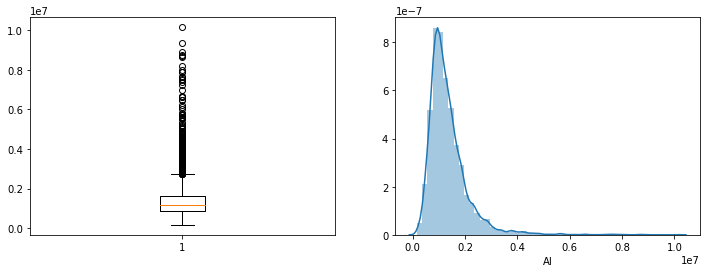

In [26]:
show_feature_outliers(df,'AI')

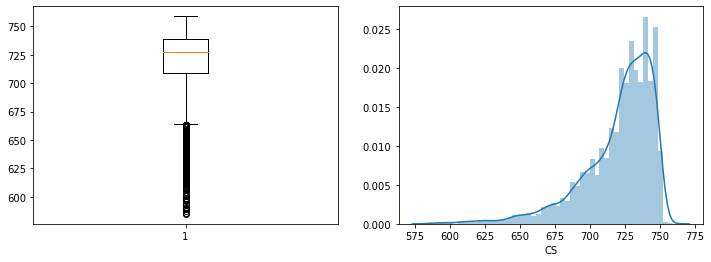

In [27]:
show_feature_outliers(df,'CS')

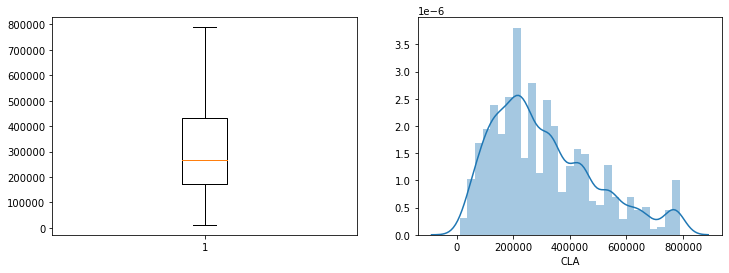

In [28]:
show_feature_outliers(df,'CLA')

Общая функция предобработки

In [29]:
def prep_all_get_cats(df):
    prep_outlier(df)
    prep_fillna(df)
    CAT_FEATS = obj_to_cat(df)
    fillna_model(df, 'AI', MODEL_AI_FILE_PATH)
    fillna_model(df, 'CS', MODEL_CS_FILE_PATH)
    fillna_model(df, 'CLA', MODEL_CLA_FILE_PATH, cla_nan=True)
    return CAT_FEATS

## Подбор гиперпараметров

In [30]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## Валидация

In [31]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.columns = SHORT_COLUMNS

y = df['CD']
X = df.copy().drop(['CD'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)


prep_all_get_cats(X_train)
prep_all_get_cats(X_test)

valid_model = catb.CatBoostClassifier( class_weights=[1,2.6267],
                                     cat_features = CAT_FEATS,
                                     l2_leaf_reg = 10,
                                     n_estimators=300, 
                                     max_depth=8, 
                                     silent=True, 
                                     random_state=4)

valid_model.fit(X_train, y_train)

y_train_pred = valid_model.predict(X_train)
y_test_pred = valid_model.predict(X_test)
y_test_pred_probs = valid_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      4074
           1       0.49      0.78      0.61      1551

    accuracy                           0.72      5625
   macro avg       0.69      0.74      0.69      5625
weighted avg       0.78      0.72      0.73      5625

TEST

              precision    recall  f1-score   support

           0       0.81      0.64      0.71      1313
           1       0.44      0.66      0.53       562

    accuracy                           0.64      1875
   macro avg       0.63      0.65      0.62      1875
weighted avg       0.70      0.64      0.66      1875

CONFUSION MATRIX

col_0    0    1
CD             
0      834  479
1      190  372


Регулировка порога

In [32]:
y_p = np.array(y_test_pred_probs[:,1]>0.57).astype('int')
get_classification_report(y_train,y_train_pred,y_test,y_p)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.69      0.78      4074
           1       0.49      0.78      0.61      1551

    accuracy                           0.72      5625
   macro avg       0.69      0.74      0.69      5625
weighted avg       0.78      0.72      0.73      5625

TEST

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      1313
           1       0.47      0.47      0.47       562

    accuracy                           0.68      1875
   macro avg       0.62      0.62      0.62      1875
weighted avg       0.68      0.68      0.68      1875

CONFUSION MATRIX

col_0     0    1
CD              
0      1020  293
1       298  264


## Финальная модель

In [33]:
# тренировочные данные
train_data = pd.read_csv(TRAIN_DATASET_PATH)
train_data.columns = SHORT_COLUMNS
y_train = train_data['CD']
X_train = train_data.copy().drop(['CD'],axis=1)

# тестовые данные
X_test = pd.read_csv(TEST_DATASET_PATH)
X_test.columns = SHORT_COLUMNS[:-1]

# предобработка тренировочных и тестовых данных
CAT_FEATS = prep_all_get_cats(X_train)
prep_all_get_cats(X_test)

# Финальная модель
final_model = catb.CatBoostClassifier( class_weights=[1,2.55],
                                     cat_features=CAT_FEATS,
                                     l2_leaf_reg=10,
                                     n_estimators=500, 
                                     max_depth=5, 
                                     silent=True, 
                                     random_state=4)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.89      0.63      0.74      5387
           1       0.46      0.79      0.58      2113

    accuracy                           0.68      7500
   macro avg       0.67      0.71      0.66      7500
weighted avg       0.77      0.68      0.70      7500



## Сохранение результата

In [34]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

pd.Series(y_test_pred).to_csv('AChernenko_predictions.csv',index=None)

#### Черновики

In [35]:
# ##BOX_COX - ничего не дает
# LOGNORM_FEATS = ['AI','NOA','YCH','MD', 'MOC', 'CCB', 'MD', 'CLA']
# 
# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer(method='box-cox')
# X_train[LOGNORM_FEATS] = pt.fit_transform(X_train[LOGNORM_FEATS])
# X_test[LOGNORM_FEATS] = pt.transform(X_test[LOGNORM_FEATS])
# 
# NUM_FEATS = list(X.select_dtypes(include='float64').columns)
# 
# # стандартизация
# scaler = StandardScaler(with_mean=False)
# X_train_num = scaler.fit_transform(X_train[NUM_FEATS])
# X_test_num = scaler.transform(X_test[NUM_FEATS])
# 
# # понижение размерности
# pca = PCA(n_components=None, random_state=100)
# X_train_num = pca.fit_transform(X_train_num)  
# X_test_num = pca.transform(X_test_num)  
# 
# # объединение обработанных числовых и категорийных призныков
# X_train = pd.concat([pd.DataFrame(X_train_num, index=y_train.index), X_train[CAT_FEATS]], axis=1)
# X_test = pd.concat([pd.DataFrame(X_test_num, index=y_test.index), X_test[CAT_FEATS]], axis=1)

In [36]:
# def show_feature_importances(feature_names, feature_importances, get_top=None):
#     feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
#     feature_importances = feature_importances.sort_values('importance', ascending=False)
#        
#     plt.figure(figsize = (20, len(feature_importances) * 0.355))
#     
#     sns.barplot(feature_importances['importance'], feature_importances['feature'])
#     
#     plt.xlabel('Importance')
#     plt.title('Importance of features')
#     plt.show()
#     
#     if get_top is not None:
#         return feature_importances['feature'][:get_top].tolist()
# 
#     
# important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [37]:
# plt.figure(figsize = (15,10))
# 
# sns.set(font_scale=1.4)
# sns.heatmap(df.corr().round(2),annot=True,cmap='RdYlGn',vmin=-1,vmax=1)

In [38]:
# def feature_importance_table(X, model):    
#     return pd.DataFrame(zip(X.columns,model.feature_importances_),columns=['Feature_name','Importance']).sort_values(['Importance'],ascending=False)